
# Validation of QSAR model applicability

## Packages and working directory

In [1]:
import os
import subprocess
import pandas as pd
import numpy as np
from IPython.display import Image
from functools import reduce

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from itertools import groupby

from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Draw.MolDrawing import DrawingOptions
DrawingOptions.includeAtomNumbers=True


In [2]:
Projectdir = "C:\\Users\\Hannah\\OneDrive - Uva\\Master UvA\\master project\\design_additions_after_msc"
os.chdir(Projectdir)
print("Current Working Directory: " , os.getcwd())

Current Working Directory:  C:\Users\Hannah\OneDrive - Uva\Master UvA\master project\design_additions_after_msc


## Functions for model applicability validation

In [3]:
def show_mol_grid(mols):
    '''draws molecules in grid, needs to be last command in cell'''
    return MolsToGridImage(mols
        , subImgSize=(250,200)
        ,molsPerRow=3
    )

def drawsmileslist(smileslist):
    '''draws molecules from list of smiles in grid, needs to be last command in cell'''
    mols = []
    for smiles in smileslist:
        mols.append(Chem.MolFromSmiles(smiles))
    return(show_mol_grid(mols)
    )

def molslistt(df):
    '''Converts SMILES column of dataframe into a list of rdkit mols.'''
    out_mols = []
    for smiles in df['SMILES']:
        mol = Chem.MolFromSmiles(smiles)
        out_mols.append(mol)
    return out_mols

def CheckValidity(molset):
    '''Input a list of mols, returns a dictionary of two items, keys= 'P containing molecules', 
    'Phosphoester containing molecules', values are correcponding lists of smiles contained in input mol list'''
    phosphoester = Chem.MolFromSmarts("[$(P(=[OX1])([OX2][#6])([$([OX2H]),$([OX1-]),$([OX2][#6])])[$([OX2H]),$([OX1-]),$([OX2][#6]),$([OX2]P)]),$([P+]([OX1-])([OX2][#6])([$([OX2H]),$([OX1-]),$([OX2][#6])])[$([OX2H]),$([OX1-]),$([OX2][#6]),$([OX2]P)])]")
    P = Chem.MolFromSmarts("[P]")
    S = Chem.MolFromSmarts("[S]")

    nPester = 0
    nP = 0
    nerrors = 0
    phosphoestsmiles = []
    Psmiles = []
    max_molwt = 0.0
    min_molwt = 1000.0
    for mol in molset:
        try:
            if mol.HasSubstructMatch(phosphoester):
                nPester += 1
                phosphoestsmiles.append(Chem.MolToSmiles(mol))
            if mol.HasSubstructMatch(P): #and mol.HasSubstructMatch(S):
                nP += 1
                Psmiles.append(Chem.MolToSmiles(mol))
            if float(Chem.Descriptors.MolWt(mol)) >= max_molwt:
                max_molwt = float(Chem.Descriptors.MolWt(mol))
            if float(Chem.Descriptors.MolWt(mol)) <= min_molwt:
                if float(Chem.Descriptors.MolWt(mol)) > 0: #one mol in KOCWIN dataset gave 0 as MW, not realistic
                    min_molwt = Chem.Descriptors.MolWt(mol)
        except:
            nerrors += 1
    print('Errors encountered: ', nerrors, 
          ' ,probably NoneType errors from input file. \nMolecules containing a phosphoester moeiety:', nPester)
    print('Molecules containing at least one P:', nP)
    print('Total number of molecules in dataset:', len(molset))
    print('Maximum MW in dataset is ', max_molwt,
         'Minimum MW in dataset is ', min_molwt)
    outdict = dict(zip(['P containing molecules', 'Phosphoester containing molecules'],[Psmiles,phosphoestsmiles]))

    return outdict

def CheckLogKowRange(KOWWINfile):
    '''Prints the minimum and maximum experimental and estimated logKow reported in KOWWINfile 
    and returns them as dictionary'''
    # Skip rows starting with *, EPiSuite KOWWIN marks incompatible smiles with ***
    logkows = pd.read_csv(KOWWINfile, sep='\t', 
                          names= ['LogKow_Estimated','LogKow_Experimental','SMILES'],
                                  na_values= '----',comment = '*',skip_blank_lines=True)
    #logkows['LogKow_Estimated'] = pd.to_numeric(logkows['LogKow_Estimated'])
    #logkows['LogKow_Experimental'] = pd.to_numeric(logkows['LogKow_Experimental'])#, errors='coerce'
    min_exp = logkows['LogKow_Experimental'].min()
    max_exp = logkows['LogKow_Experimental'].max()
    min_est = logkows['LogKow_Estimated'].min()
    max_est = logkows['LogKow_Estimated'].max()
    outdict = dict(zip(['Min LogKow exp','Max LogKow exp', 'Min LogKow est', 'Max LogKow est'],
                       [min_exp, max_exp, min_est, max_est]))
    print(outdict)
    return outdict


*** 
## Episuite model applicability check
Datasets were accessed through the manual available in the application interface.



In [4]:
os.chdir(Projectdir + "\\qsar_validation\\training_sets")

### Biowin

from manual, the data is available here: http://esc.syrres.com/interkow/EpiSuiteData_ISIS_SDF.htm  
  Updated on September 15, 2010  
  Accessed on July 13, 2020, 18:30

In [5]:
BiowinData = Chem.SDMolSupplier('EPI_Biowin_Data_SDF.sdf') #training and test data sets of the biowin model

Errors encountered:  6  ,probably NoneType errors from input file. 
Molecules containing a phosphoester moeiety: 20
Molecules containing at least one P: 45
Total number of molecules in dataset: 1263
Maximum MW in dataset is  959.1709999999999 Minimum MW in dataset is  30.025999999999996


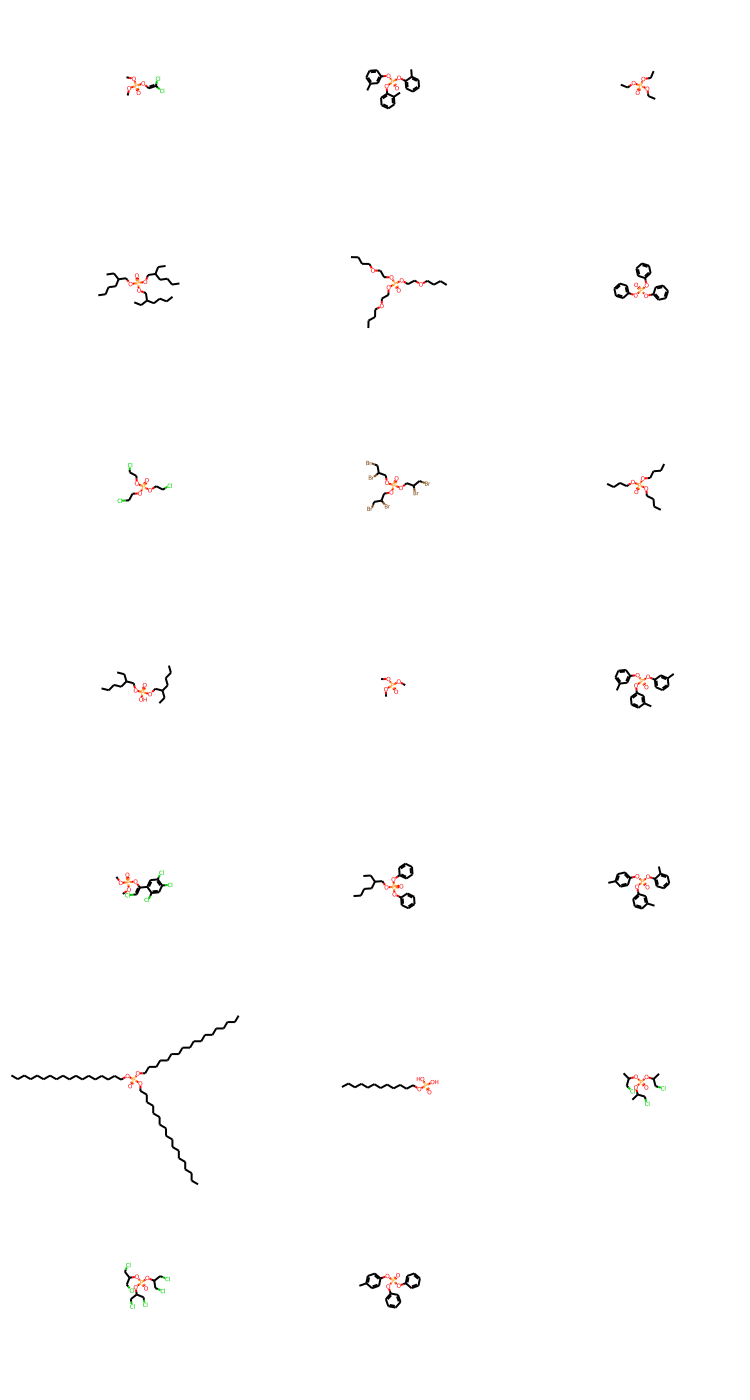

In [6]:
drawsmileslist(CheckValidity(BiowinData)['Phosphoester containing molecules'])

Conclusion:  
There are at least 20 phosphoester containing molecules in the Biowin model training and validation sets. Some of them have a high similarity to tibp, for example tnbp, triethylphosphate, trimethylphosphate, triC18phosphoester linear, etc.


### KOWWIN

In [7]:
KOWWINData = Chem.SDMolSupplier('EPI_Kowwin_Data_SDF.sdf')
len(KOWWINData)

15809

Errors encountered:  371  ,probably NoneType errors from input file. 
Molecules containing a phosphoester moeiety: 66
Molecules containing at least one P: 362
Total number of molecules in dataset: 15809
Maximum MW in dataset is  1202.634999999998 Minimum MW in dataset is  4.003


C:\Users\Hannah\anaconda3\envs\rdkitenv\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:190: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


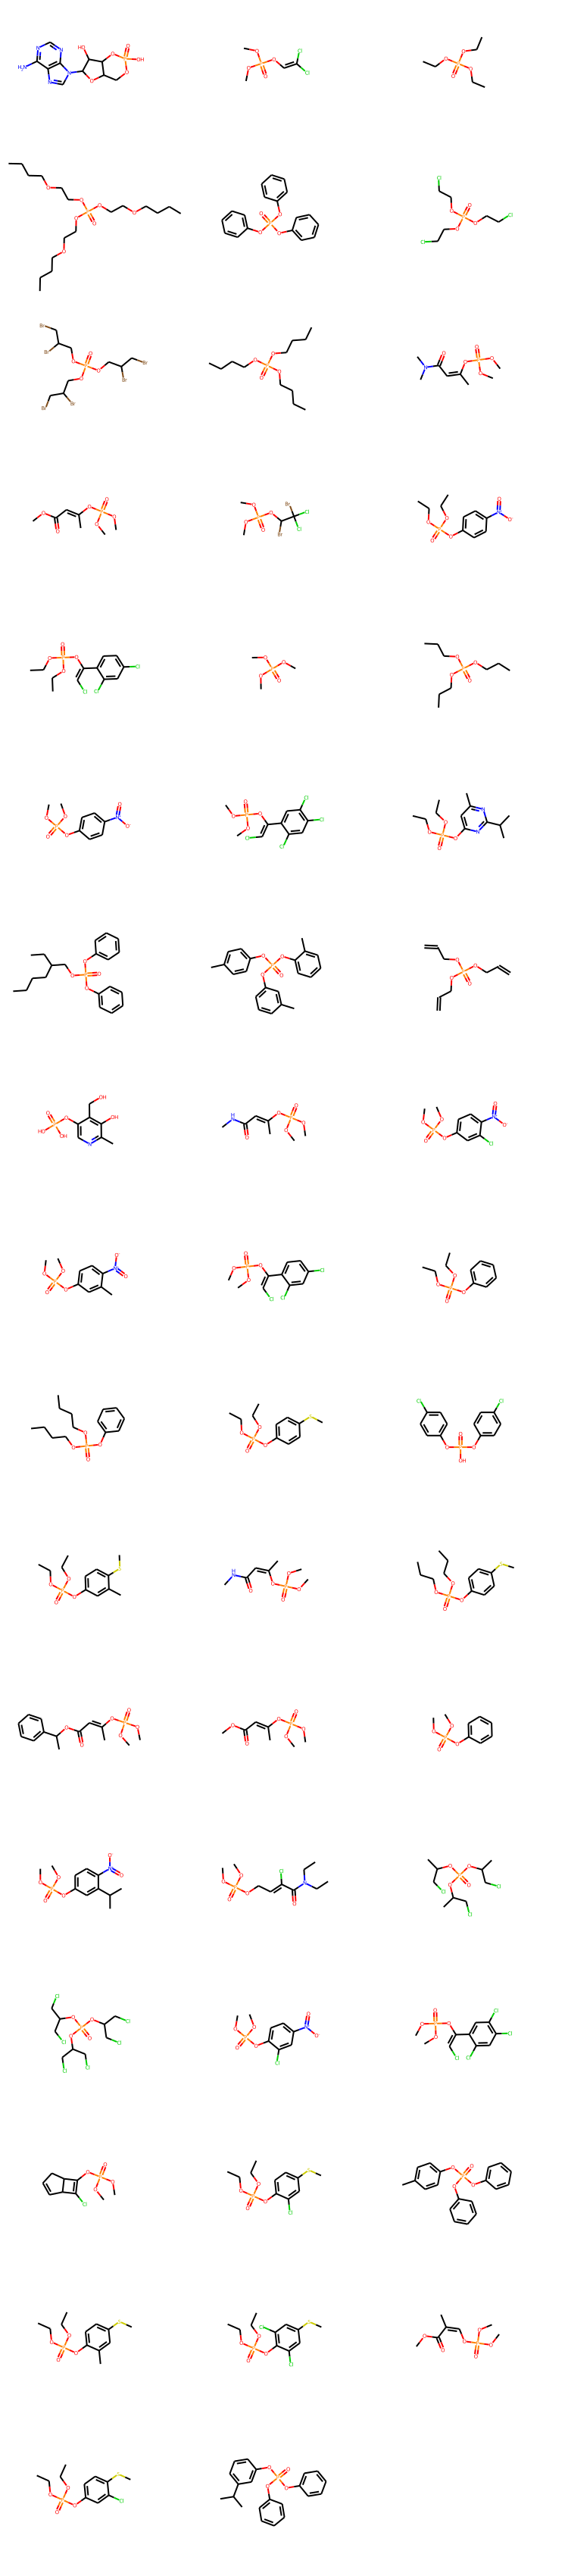

In [8]:
drawsmileslist(CheckValidity(KOWWINData)['Phosphoester containing molecules'])

Conclusion: 66 organophosphate structures in the log Kow training set with sufficient similarity to tibp and the kind of structures generated in silico.

### BCFBAF

In [9]:
EpiBCFData = Chem.SDMolSupplier('EPI_BCF_Data_SDF.sdf')
len(EpiBCFData)

685

Errors encountered:  0  ,probably NoneType errors from input file. 
Molecules containing a phosphoester moeiety: 21
Molecules containing at least one P: 60
Total number of molecules in dataset: 685
Maximum MW in dataset is  991.832 Minimum MW in dataset is  68.075


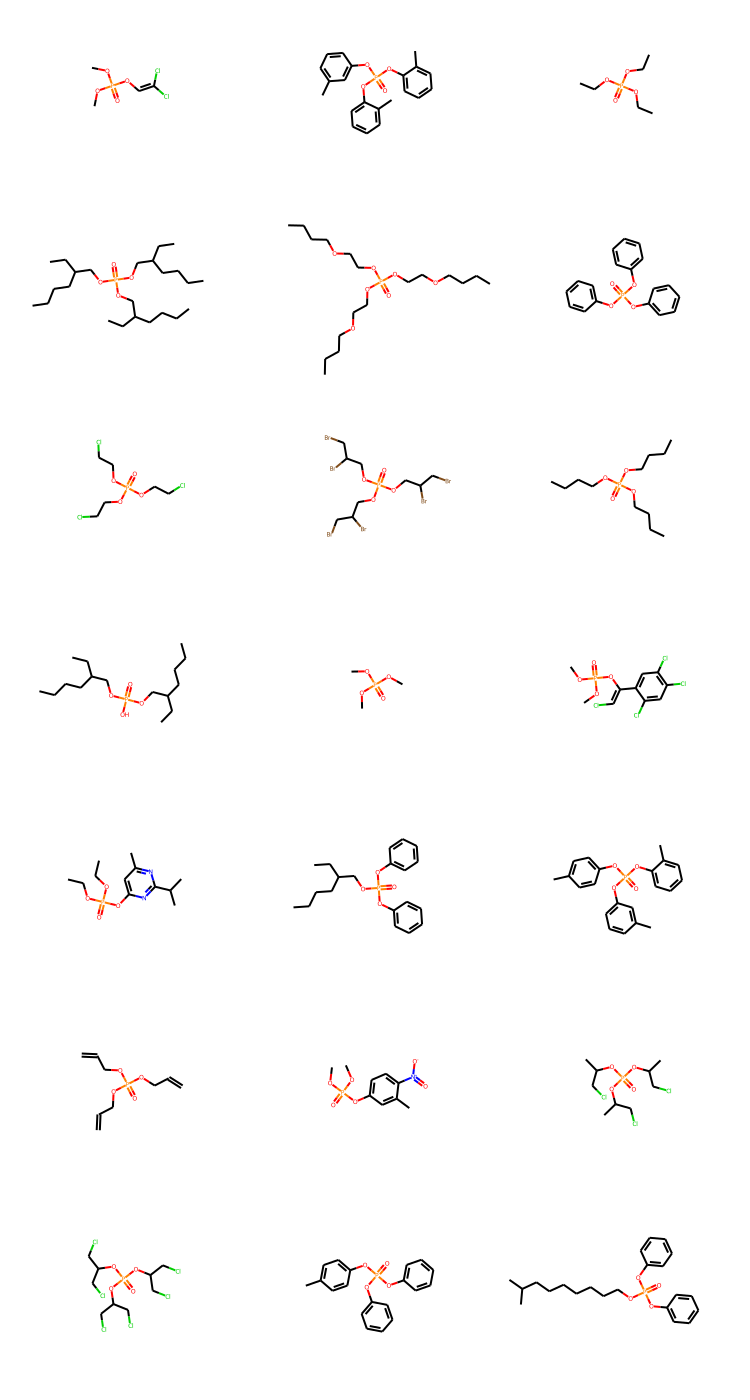

In [10]:
drawsmileslist(CheckValidity(EpiBCFData)['Phosphoester containing molecules'])

Conclusion: 21 organophosphate structures in the BCF training set with sufficient similarity to tibp and the kind of structures generated in silico.

### KOCWIN

In [11]:
KOCWINData = Chem.SDMolSupplier('EPI_PCKOC_Data_SDF.sdf')
len(KOCWINData)

788

Errors encountered:  4  ,probably NoneType errors from input file. 
Molecules containing a phosphoester moeiety: 13
Molecules containing at least one P: 74
Total number of molecules in dataset: 788
Maximum MW in dataset is  1052.7050000000006 Minimum MW in dataset is  32.042


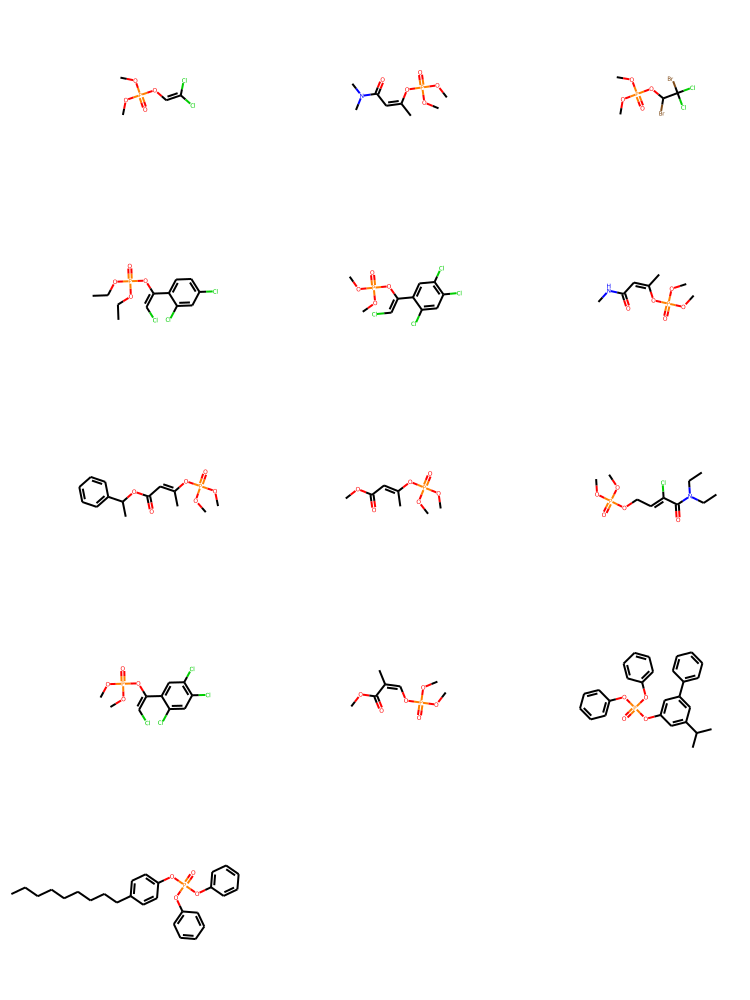

In [12]:
drawsmileslist(CheckValidity(KOCWINData)['Phosphoester containing molecules'])

Conclusion: There are 13 organophosphates in the training set of the Koc model 

## VEGA models applicability check
Data from the individual models can be found in the manual and were accessed through the application interface.

### OPERA KOC

In [33]:
KocOPERAtraining = pd.read_csv(Projectdir+'\\qsar_validation\\training_sets\\dataset_KOC_OPERA.txt', 
                               sep='\t', names=['SMILES']) #training dataset of VEGA OPERA KOc model
    
Koc_OPERA_mols = molslistt(KocOPERAtraining)


Errors encountered:  0  ,probably NoneType errors from input file. 
Molecules containing a phosphoester moeiety: 9
Molecules containing at least one P: 68
Total number of molecules in dataset: 729
Maximum MW in dataset is  665.0140000000001 Minimum MW in dataset is  32.042


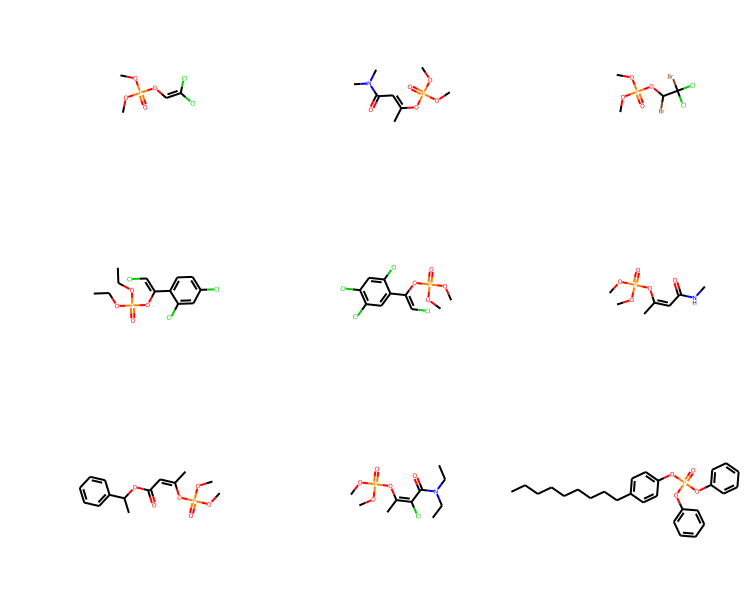

In [34]:
drawsmileslist(CheckValidity(Koc_OPERA_mols)['Phosphoester containing molecules'])

Conclusions: Nine organophosphates in training set and several organothiophosphates, no purely alkyl phosphates. 

### IRFMN water solubility

Errors encountered:  0  ,probably NoneType errors from input file. 
Molecules containing a phosphoester moeiety: 52
Molecules containing at least one P: 207
Total number of molecules in dataset: 5018
Maximum MW in dataset is  1139.7640000000001 Minimum MW in dataset is  26.037999999999997


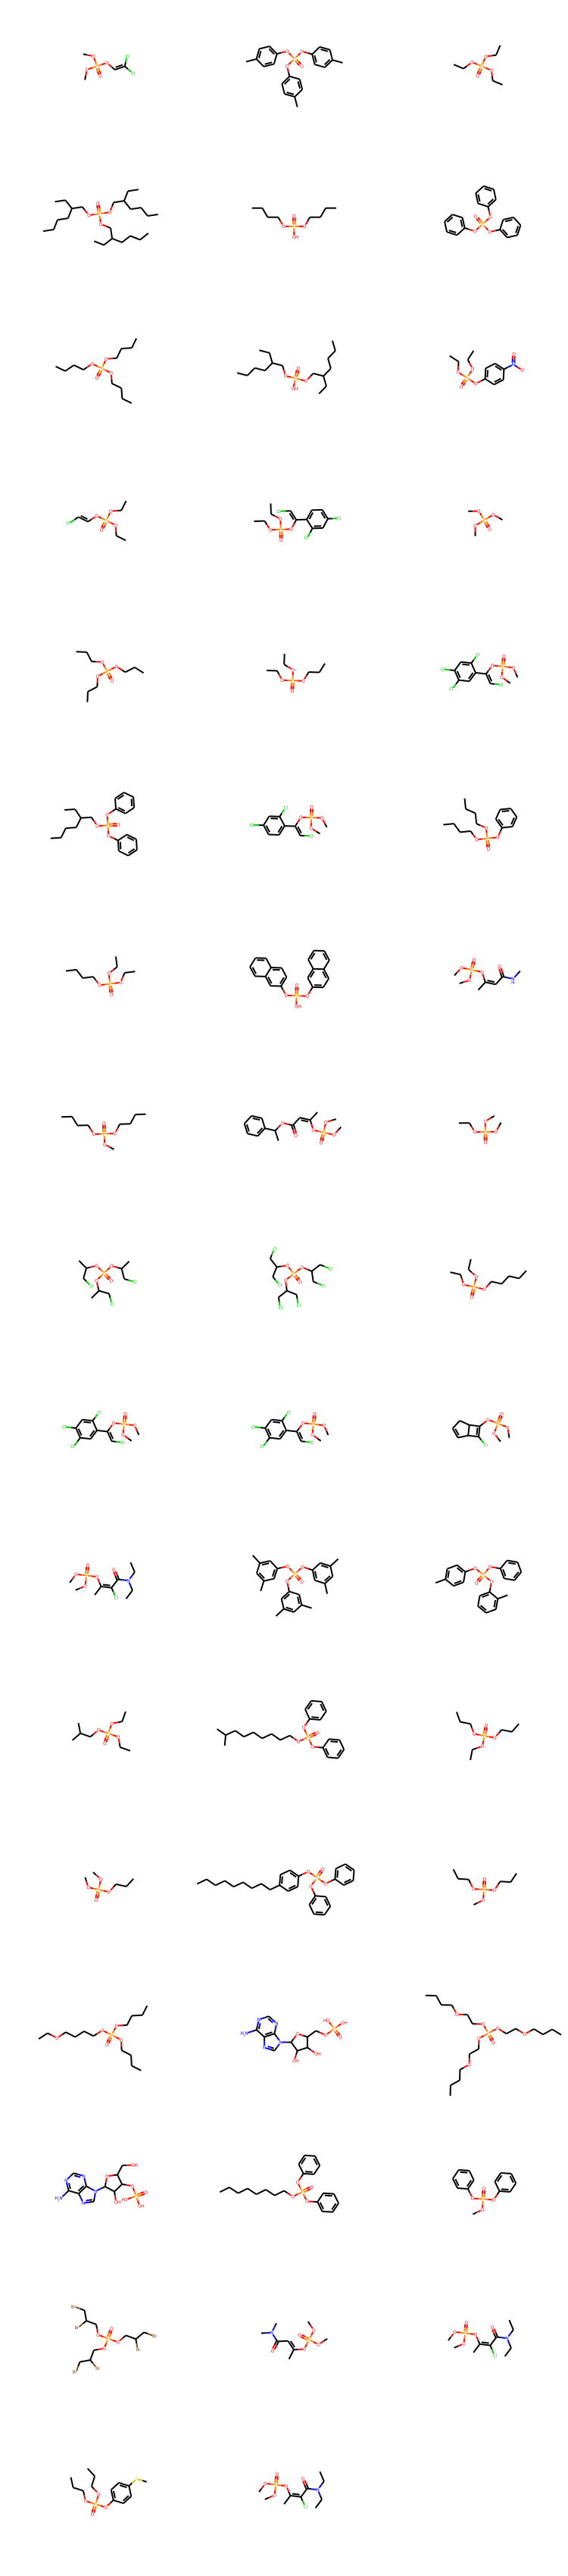

In [36]:
WS_IRFMN_training_set = pd.read_csv(Projectdir+'\\qsar_validation\\training_sets\\dataset_WS_IRFMN.txt', 
                               sep='\t', names=['SMILES']) #training dataset of VEGA OPERA KOc model
    
WS_IRFMN_mols = molslistt(WS_IRFMN_training_set)
drawsmileslist(CheckValidity(WS_IRFMN_mols)['Phosphoester containing molecules'])

Conclusions: more than 50 molecules in training set are organophosphates, contains organophosphates with different alkyl chains, model is applicable to generated structures.

### VEGA human toxicity: carcinogenicity, endocrine disruption, skin sensitization

In [37]:
os.chdir(Projectdir+'\\qsar_validation\\training_sets\\htox_training_sets')
htox_training_set_names = os.listdir()
print(htox_training_set_names)

htox_training_sets = {htox_training_set_names[n]: pd.read_csv(file, sep = "\t") 
      for n,file in enumerate(htox_training_set_names)}

['dataset_ANDROGEN_COMPARA.txt', 'dataset_CARC_ANTARES.txt', 'dataset_CARC_CAESAR.txt', 'dataset_CARC_ISS.txt', 'dataset_CARC_ISSCAN-CGX.txt', 'dataset_ESTROGEN_CERAPP.txt', 'dataset_RBA_IRFMN.txt', 'dataset_SKIN_CAESAR.txt', 'dataset_SKIN_IRFMN.txt', 'dataset_TRALPHA_NRMEA.txt', 'dataset_TRBETA_NRMEA.txt']


In [38]:
for name,training_set in htox_training_sets.items():
    print(name,'\t')
    CheckValidity(molslistt(training_set))

dataset_ANDROGEN_COMPARA.txt 	
Errors encountered:  0  ,probably NoneType errors from input file. 
Molecules containing a phosphoester moeiety: 22
Molecules containing at least one P: 73
Total number of molecules in dataset: 1664
Maximum MW in dataset is  1701.2060000000008 Minimum MW in dataset is  42.041
dataset_CARC_ANTARES.txt 	
Errors encountered:  0  ,probably NoneType errors from input file. 
Molecules containing a phosphoester moeiety: 10
Molecules containing at least one P: 37
Total number of molecules in dataset: 1543
Maximum MW in dataset is  1255.4379999999987 Minimum MW in dataset is  30.025999999999996
dataset_CARC_CAESAR.txt 	
Errors encountered:  0  ,probably NoneType errors from input file. 
Molecules containing a phosphoester moeiety: 3
Molecules containing at least one P: 23
Total number of molecules in dataset: 806
Maximum MW in dataset is  1255.4379999999987 Minimum MW in dataset is  30.025999999999996
dataset_CARC_ISS.txt 	
Errors encountered:  0  ,probably NoneTy

Errors encountered:  0  ,probably NoneType errors from input file. 
Molecules containing a phosphoester moeiety: 10
Molecules containing at least one P: 37
Total number of molecules in dataset: 1543
Maximum MW in dataset is  1255.4379999999987 Minimum MW in dataset is  30.025999999999996


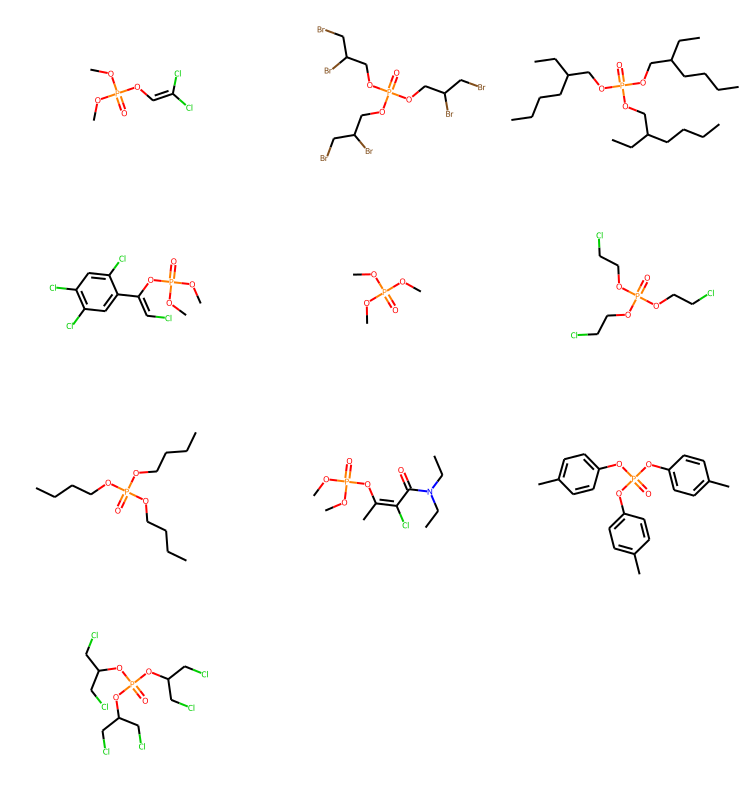

In [39]:
drawsmileslist(CheckValidity(molslistt(htox_training_sets['dataset_CARC_ANTARES.txt']))['Phosphoester containing molecules'])

Conclusions: <br>
Both VEGA models for skin sensitization don't include any P containing molecules in their training sets. They are therefore considered to be non-applicable to the generated structures. <br>
Carcinogenicity models have very small number of organophosphates in training set, CAESAR model only 3 (of which 2 halogenated), Antares 10 (of which 6 halogenated, two aromatic), ISS 7 (of which 4 halogenated, 2 aromatic), ISSCAN-CGX same as ISS. Plus several organothiophosphates and organophosphoramides.  <br>
RBA_IRFMN (estrogen relative binding affinity) has 6 organophosphates, of which three are halogenated and two aromatic,other EDC models have 20 or more organophosphates, also with three alkyl chains, so should be applicable to generated structures.  

### VEGA Mutagenicity consesus model

In [44]:
QSARdir = Projectdir+'\\qsar_validation\\training_sets'
os.chdir(QSARdir)
caesar = pd.read_csv('dataset_MUTA_CAESAR.txt', sep='\t', names=['SMILES']) #training and test data sets of the caesar model
ISS = pd.read_csv('dataset_MUTA_ISS.txt', sep='\t', names=['SMILES']) #training and test data sets of the ISS model
KNN = pd.read_csv('dataset_MUTA_KNN.txt', sep='\t', names=['SMILES']) #training and test data sets of the KNN model
SARPY = pd.read_csv('dataset_MUTA_SARPY.txt', sep='\t', names=['SMILES']) #training and test data sets of the SARPY model

muta_training_sets = {'dataset_MUTA_CAESAR.txt':caesar,'dataset_MUTA_ISS.txt':ISS, 'dataset_MUTA_KNN.txt':KNN,
                  'dataset_MUTA_SARPY.txt':SARPY}

caesar_mols = molslistt(caesar)
ISS_mols = molslistt(ISS)
KNN_mols = molslistt(KNN)
SARPY_mols = molslistt(SARPY)
alllist= caesar_mols + ISS_mols + KNN_mols +SARPY_mols
VEGA_molset = set(alllist)

Caesar
Errors encountered:  0  ,probably NoneType errors from input file. 
Molecules containing a phosphoester moeiety: 42
Molecules containing at least one P: 102
Total number of molecules in dataset: 4204
Maximum MW in dataset is  3080.497999999993 Minimum MW in dataset is  30.025999999999996
ISS
Errors encountered:  0  ,probably NoneType errors from input file. 
Molecules containing a phosphoester moeiety: 8
Molecules containing at least one P: 29
Total number of molecules in dataset: 670
Maximum MW in dataset is  1255.4379999999987 Minimum MW in dataset is  30.025999999999996
KNN
Errors encountered:  6  ,probably NoneType errors from input file. 
Molecules containing a phosphoester moeiety: 42
Molecules containing at least one P: 117
Total number of molecules in dataset: 5770
Maximum MW in dataset is  1550.1879999999996 Minimum MW in dataset is  28.009999999999998
SARPY
Errors encountered:  0  ,probably NoneType errors from input file. 
Molecules containing a phosphoester moeiety: 

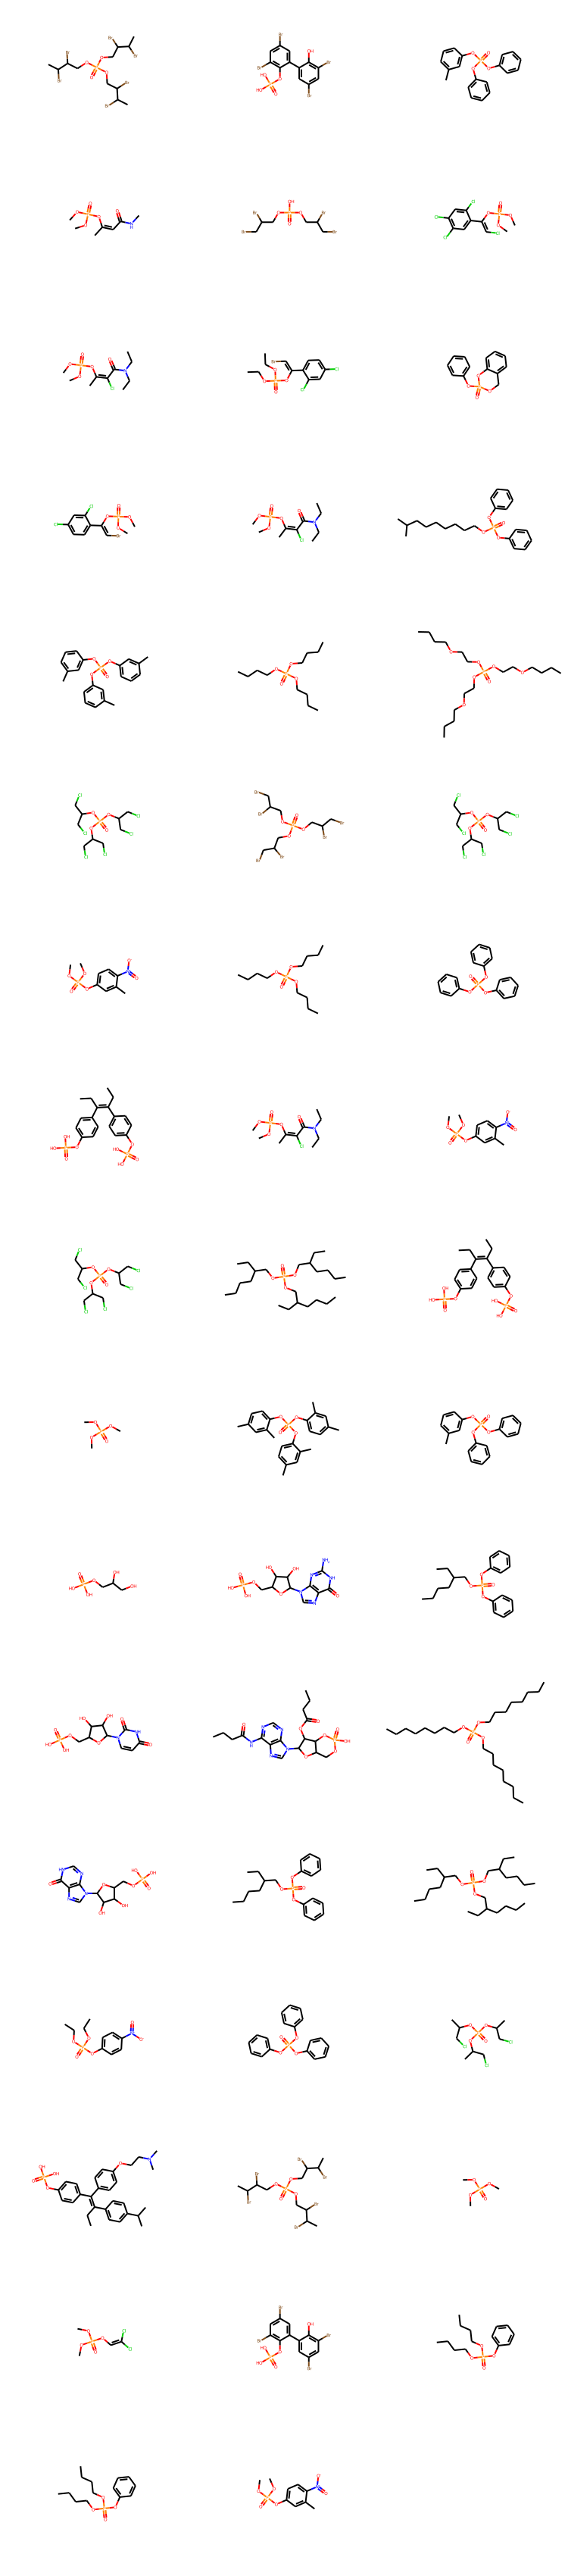

In [45]:
print('Caesar')
CheckValidity(caesar_mols)
print('ISS')
CheckValidity(ISS_mols)
print('KNN')
CheckValidity(KNN_mols)
print('SARPY')
CheckValidity(SARPY_mols)
print('all together, VEGA')
drawsmileslist(CheckValidity(VEGA_molset)['Phosphoester containing molecules'])

Conclusions: There are organophosphate molecules including different alkyl organophosphates in the datasets of all models, applicable to generated structures. ISS submodel has only few organophosphates in training set.

### VEGA ecotoxicity models

In [46]:
os.chdir(Projectdir+'\\qsar_validation\\training_sets\\ecotox_training_sets')
ecotox_training_set_names = os.listdir()
print(ecotox_training_set_names)

ecotox_training_sets = {ecotox_training_set_names[n]: pd.read_csv(file, sep = "\t") 
      for n,file in enumerate(ecotox_training_set_names)}

['dataset_ALGAE_NOEC_IRFMN.txt', 'dataset_DAPHNIA_COMBASE.txt', 'dataset_DAPHNIA_DEMETRA.txt', 'dataset_DAPHNIA_EC50_IRFMN.txt', 'dataset_DAPHNIA_EPA.txt', 'dataset_FISH_COMBASE.txt', 'dataset_FISH_IRFMN_SARPY.txt', 'dataset_FISH_KNN.txt', 'dataset_FISH_LC50_IRFMN.txt', 'dataset_FISH_NIC.txt']


In [47]:
for name,training_set in ecotox_training_sets.items():
    print(name,'\t')
    CheckValidity(molslistt(training_set))

dataset_ALGAE_NOEC_IRFMN.txt 	
Errors encountered:  0  ,probably NoneType errors from input file. 
Molecules containing a phosphoester moeiety: 1
Molecules containing at least one P: 5
Total number of molecules in dataset: 410
Maximum MW in dataset is  546.7890000000003 Minimum MW in dataset is  41.053
dataset_DAPHNIA_COMBASE.txt 	
Errors encountered:  0  ,probably NoneType errors from input file. 
Molecules containing a phosphoester moeiety: 0
Molecules containing at least one P: 12
Total number of molecules in dataset: 133
Maximum MW in dataset is  1052.7049999999997 Minimum MW in dataset is  30.025999999999996
dataset_DAPHNIA_DEMETRA.txt 	
Errors encountered:  0  ,probably NoneType errors from input file. 
Molecules containing a phosphoester moeiety: 4
Molecules containing at least one P: 30
Total number of molecules in dataset: 263
Maximum MW in dataset is  1052.7049999999997 Minimum MW in dataset is  73.12
dataset_DAPHNIA_EC50_IRFMN.txt 	
Errors encountered:  0  ,probably NoneType

Errors encountered:  0  ,probably NoneType errors from input file. 
Molecules containing a phosphoester moeiety: 3
Molecules containing at least one P: 14
Total number of molecules in dataset: 567
Maximum MW in dataset is  488.59299999999996 Minimum MW in dataset is  32.042


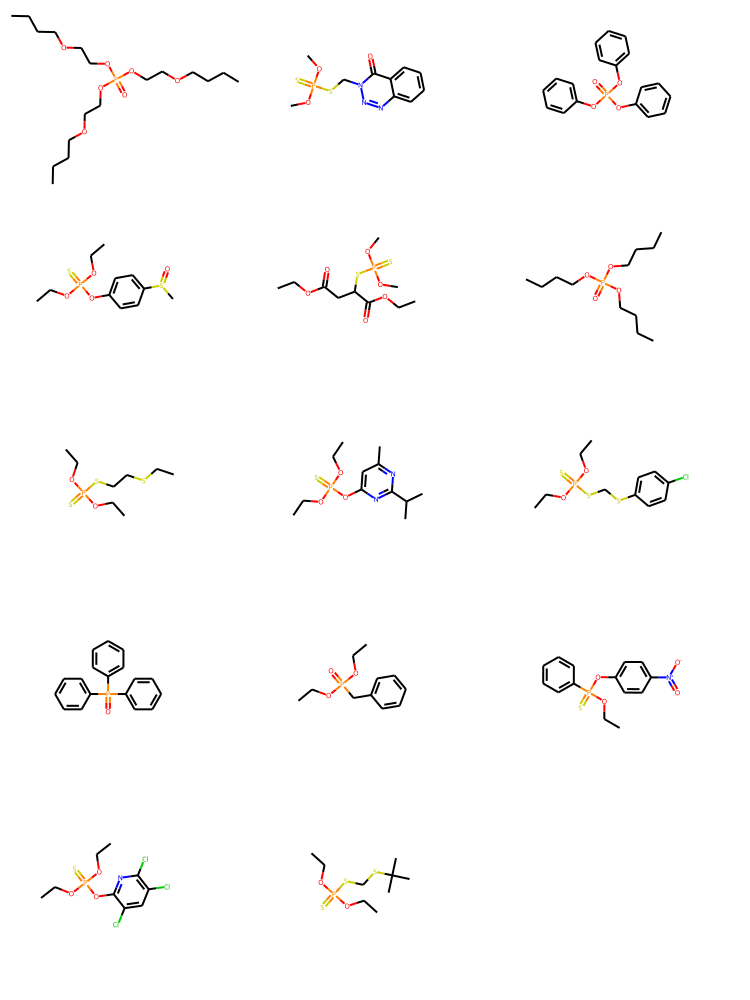

In [48]:
drawsmileslist(CheckValidity(molslistt(ecotox_training_sets['dataset_FISH_IRFMN_SARPY.txt']))
               ['P containing molecules'])

Generally, only very few organophosphates in ecotox model training sets.
Algae NOEC IRFMN only five P containing, of which three aromatic organothiophosphates, Daphnia COMBASE has no phosphoester contianing molecules, and few P containing molecules at all. <br>
Due to the complexity of the toxicity endpoint, and the mechanistic relevance of halogens and aromatics contained in the phosphate esters from th training set, these models are rather not applicable for use with the generated structures in the design approach.


### VEGA persistency models

In [49]:
os.chdir(Projectdir+'\\qsar_validation\\training_sets\\persistency_training_sets')
persistency_training_set_names = os.listdir()
print(persistency_training_set_names)

persistency_training_sets = {persistency_training_set_names[n]: pd.read_csv(file, sep = "\t") 
      for n,file in enumerate(persistency_training_set_names)}

['dataset_PERS_SED_QUANT_IRFMN.txt', 'dataset_PERS_SOIL_QUANT_IRFMN.txt', 'dataset_PERS_WATER_QUANT_IRFMN.txt']


In [50]:
for name,training_set in persistency_training_sets.items():
    print(name,'\t')
    CheckValidity(molslistt(training_set))

dataset_PERS_SED_QUANT_IRFMN.txt 	
Errors encountered:  0  ,probably NoneType errors from input file. 
Molecules containing a phosphoester moeiety: 0
Molecules containing at least one P: 5
Total number of molecules in dataset: 221
Maximum MW in dataset is  545.5459999999998 Minimum MW in dataset is  54.09199999999999
dataset_PERS_SOIL_QUANT_IRFMN.txt 	
Errors encountered:  0  ,probably NoneType errors from input file. 
Molecules containing a phosphoester moeiety: 0
Molecules containing at least one P: 6
Total number of molecules in dataset: 226
Maximum MW in dataset is  545.5459999999998 Minimum MW in dataset is  54.09199999999999
dataset_PERS_WATER_QUANT_IRFMN.txt 	
Errors encountered:  0  ,probably NoneType errors from input file. 
Molecules containing a phosphoester moeiety: 0
Molecules containing at least one P: 5
Total number of molecules in dataset: 223
Maximum MW in dataset is  545.5459999999998 Minimum MW in dataset is  54.09199999999999


Errors encountered:  0  ,probably NoneType errors from input file. 
Molecules containing a phosphoester moeiety: 0
Molecules containing at least one P: 6
Total number of molecules in dataset: 226
Maximum MW in dataset is  545.5459999999998 Minimum MW in dataset is  54.09199999999999


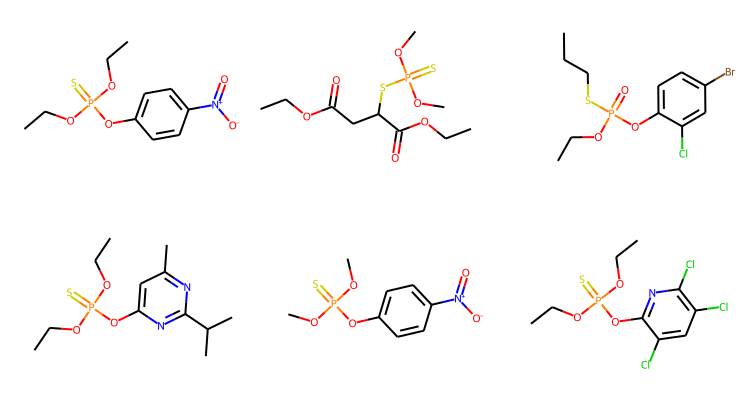

In [51]:
drawsmileslist(CheckValidity(molslistt(persistency_training_sets['dataset_PERS_SOIL_QUANT_IRFMN.txt']))
               ['P containing molecules'])

Conclusions: 
No phosphoester containg molecules, P containing aromatic organothiophosphates. Not applicable.

## QSAR models log Kow range
To assess the logKow range of the training datasets of the used models, the LogKows of the contained molecuels were retreived from KOWWIN model from EPISUITE, which is connected to a database for experimental values.

In [27]:
os.chdir(Projectdir + '\\qsar_validation\\training_sets_logkow')
model_logkows = os.listdir()
                    
for model in model_logkows:
    print(model)
    CheckLogKowRange(model)

dataset_ANDROGEN_COMPARA_LogKow.txt
{'Min LogKow exp': -3.7, 'Max LogKow exp': 8.65, 'Min LogKow est': -9.66, 'Max LogKow est': 19.6}
dataset_ESTROGEN_CERAPP_LogKow.txt
{'Min LogKow exp': -3.7, 'Max LogKow exp': 8.1, 'Min LogKow est': -8.28, 'Max LogKow est': 14.54}
dataset_KOC_OPERA_LogKow.txt
{'Min LogKow exp': -5.4, 'Max LogKow exp': 8.68, 'Min LogKow est': -4.77, 'Max LogKow est': 9.18}
dataset_MUTA_CAESAR_LogKow.txt
{'Min LogKow exp': -4.22, 'Max LogKow exp': 8.65, 'Min LogKow est': -11.86, 'Max LogKow est': 17.64}
dataset_MUTA_ISS_LogKow.txt
{'Min LogKow exp': -3.7, 'Max LogKow exp': 7.6, 'Min LogKow est': -5.03, 'Max LogKow est': 12.5}
dataset_MUTA_KNN_LogKow.txt
{'Min LogKow exp': -5.4, 'Max LogKow exp': 8.65, 'Min LogKow est': -8.36, 'Max LogKow est': 23.4}
dataset_MUTA_SARPY_LogKow.txt
{'Min LogKow exp': -4.22, 'Max LogKow exp': 8.65, 'Min LogKow est': -11.86, 'Max LogKow est': 17.64}
dataset_TRALPHA_NRMEA_LogKow.txt
{'Min LogKow exp': -5.08, 'Max LogKow exp': 9.05, 'Min LogK

Log Kow range of all models matched the log Kow range of the structures generated *in silico*.